## Fine Tune a PreTrain a BERT model for Binary classification
Before this, the data must be processed, tokenized and prepared.
1. `data_processing` notebook loads raw data and prepares training,validation and test dataset
2. `data_tokenizer`notebook tokenizes the data using LiPCoT model
3. `data_prepare` notebook prepares datasets for BERT models

Here, we will use training and validation dataset for fine-tuning. Then test set is used for evaluation
### 1. Import libraries

In [1]:
import os
import joblib
from modules.bert_module import *
from modules.path_module import *
from transformers import BertForMaskedLM
from torch import cuda
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader

### 2. Load datasets
We are going to use the validation set for training the fine-tune model. The training set for the pre-trained model will be used with labels as a validation.

In [2]:
train_dataset=joblib.load( os.path.join(bert_datapath,"val_data.joblib"))
val_dataset=joblib.load( os.path.join(bert_datapath,"train_data.joblib"))
test_dataset=joblib.load(os.path.join(bert_datapath,"test_data.joblib"))

### 3. Create Fine-tune classification model

In [3]:
# load pretrain model
pretrained_model = BertForMaskedLM.from_pretrained(bert_modelpath)
# use config of pretrain model to initialize a new BERT model
model = BertForMaskedLM(pretrained_model.config)
model.resize_token_embeddings()

print('BERT Model initialized')
# use GPU
device='cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

# Instantiate the classification model
num_classes = 2  # Number of classes in classification task
classification_model = BertForSequenceClassification(model, num_classes,device)
classification_model.to(device)  # Move model to the device (e.g., GPU if available)
print('FineTune Model created')

BERT Model initialized
Running on: cuda
FineTune Model created


### 4. Configure Training 

In [4]:
num_epochs = 64 #128
training_batch_size=4
learning_rate=1.888861270702437e-05
# Define optimizer and loss function
optimizer = optim.Adam(classification_model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()#nn.CrossEntropyLoss()
bert_finetune_modelfullpath=os.path.join(bert_finetune_no_pretrain_modelpath,'finetune_bert.pt')

random_seed=42
patience=80
training_arg={
    'modelfullpath': bert_finetune_modelfullpath,
    'criterion': criterion,
    'optimizer': optimizer,
    'epochs': num_epochs,
    'patience': patience,
    'seed': random_seed
}

### 5. Create DataLoaders

In [5]:
train_loader = DataLoader(train_dataset, batch_size=training_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 6. Train and evaluate via validation set
We train using the training set and save the model that gives the best performance on the validation set

In [6]:
results= model_trainer(classification_model,train_loader,val_loader,training_arg,device)

Epoch 1/64: 100%|██████████| 35/35 [00:02<00:00, 14.96batch/s, Loss=0.662]


model state saved with validation accuracy: 54.6584


Epoch 2/64: 100%|██████████| 35/35 [00:01<00:00, 20.62batch/s, Loss=0.723]


model state saved with validation accuracy: 59.3168


Epoch 4/64: 100%|██████████| 35/35 [00:01<00:00, 20.50batch/s, Loss=0.681]


model state saved with validation accuracy: 71.4286


Epoch 24/64: 100%|██████████| 35/35 [00:01<00:00, 21.91batch/s, Loss=0.615] 


model state saved with validation accuracy: 71.7391


Epoch 31/64: 100%|██████████| 35/35 [00:01<00:00, 21.79batch/s, Loss=0.11]  


model state saved with validation accuracy: 72.9814


Epoch 38/64: 100%|██████████| 35/35 [00:01<00:00, 21.87batch/s, Loss=0.125] 


model state saved with validation accuracy: 73.9130


Epoch 45/64: 100%|██████████| 35/35 [00:01<00:00, 21.95batch/s, Loss=0.87]  


model state saved with validation accuracy: 74.5342


Epoch 64/64: 100%|██████████| 35/35 [00:01<00:00, 21.74batch/s, Loss=0.0139]


Fine tune completed


Let's plot the training and validation loss

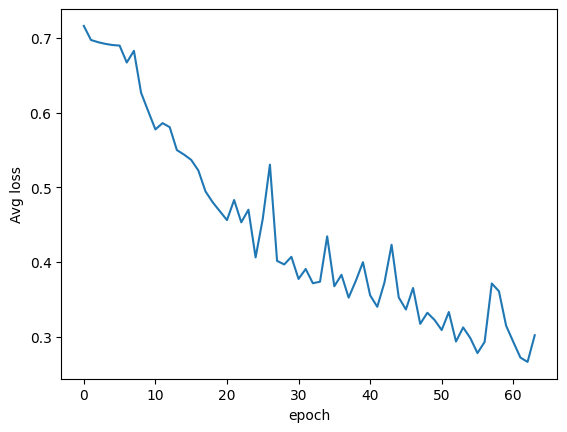

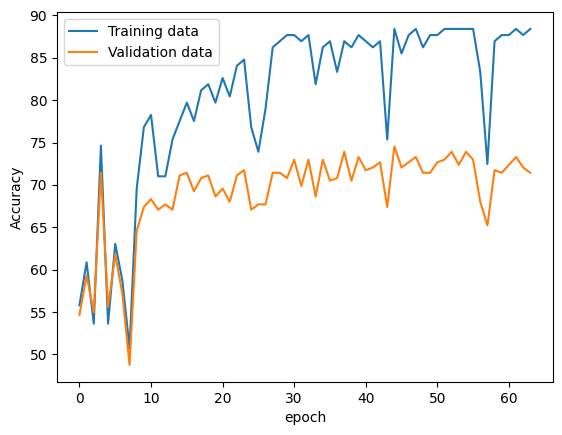

In [7]:
plt.figure()
plt.plot(results['epoch_loss'])
plt.xlabel('epoch')
plt.ylabel('Avg loss')
plt.show()


plt.figure()
plt.plot(results['training_acc'],label='Training data')
plt.plot(results['validation_acc'],label='Validation data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### 7. Evaluate model

In [8]:
best_model_state=torch.load(bert_finetune_modelfullpath, map_location=device)
classification_model.load_state_dict(best_model_state,strict=True)
classification_model.eval()
print('Fine tune model loaded')

tr_accuracy, tr_est,tr_labels,tr_scores= evaluate_binary_accuracy(classification_model, train_loader,device)
print(f'Train Binary Accuracy: {tr_accuracy:.4f}')
perf_metrics(tr_labels, tr_est,tr_scores)
print('\n')
v_accuracy,val_est,val_labels, val_scores = evaluate_binary_accuracy(classification_model, val_loader,device)
print(f'Validation Binary Accuracy: {v_accuracy:.4f}')
perf_metrics(val_labels, val_est,val_scores)
print('\n')
test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(classification_model, test_loader,device)
print(f'Test Binary Accuracy: {test_accuracy:.4f}')
perf_metrics(test_labels, test_est,test_scores)

print('Completed')

Fine tune model loaded
Train Binary Accuracy: 88.4058
Confusion Matrix:
[[72  0]
 [16 50]]
Accuracy: 88.40579710144928
Precision: 100.0
Sensitivity (Recall): 75.75757575757575
Specificity: 100.0
F1 Score: 0.8620689655172413
AUC Score: 0.9101430976430975


Validation Binary Accuracy: 74.5342
Confusion Matrix:
[[136  32]
 [ 50 104]]
Accuracy: 74.53416149068323
Precision: 76.47058823529412
Sensitivity (Recall): 67.53246753246754
Specificity: 80.95238095238095
F1 Score: 0.7172413793103448
AUC Score: 0.7680117501546073


Test Binary Accuracy: 59.7826
Confusion Matrix:
[[34 14]
 [23 21]]
Accuracy: 59.78260869565217
Precision: 60.0
Sensitivity (Recall): 47.72727272727273
Specificity: 70.83333333333334
F1 Score: 0.5316455696202532
AUC Score: 0.6150568181818182
Completed
